In [2]:
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn

In [3]:
# Necessary Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Coding Part

Index(['fish_name', 'species_name', 'temperature', 'latitude', 'longitude',
       'date_catched'],
      dtype='object')
Dataset Preview: 
       fish_name   species_name  temperature  latitude  longitude date_catched
0  Bilong-bilong  Mene Maculata         27.2      6.91     125.58   11/12/2024
1  Bilong-bilong  Mene Maculata         27.5      6.97     125.65   11/13/2024
2  Bilong-bilong  Mene Maculata         27.1      6.86     125.70   11/14/2024
3  Bilong-bilong  Mene Maculata         27.3      6.82     125.51   11/14/2024
4  Bilong-bilong  Mene Maculata         27.6      6.75     125.48   11/15/2024
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0424 - loss: 3.1061 - val_accuracy: 0.0667 - val_loss: 3.1357
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0508 - loss: 3.1016 - val_accuracy: 0.0667 - val_loss: 3.1313
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.0593 - loss: 3.0974 - val_accuracy: 0.0667 - val_loss: 3.1274
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.0678 - loss: 3.0935 - val_accuracy: 0.0667 - val_loss: 3.1235
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.0678 - loss: 3.0900 - val_accuracy: 0.0333 - val_loss: 3.1197
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.0593 - loss: 3.0868 - val_accuracy: 0.0333 - val_loss: 3.1163
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.0593 - loss: 3.0837 - val_accuracy: 0.0333 - val_loss: 3.1128
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.0593 - loss: 3.0808 - val_accuracy: 0.0333 - val_loss: 3.1093
Epoch

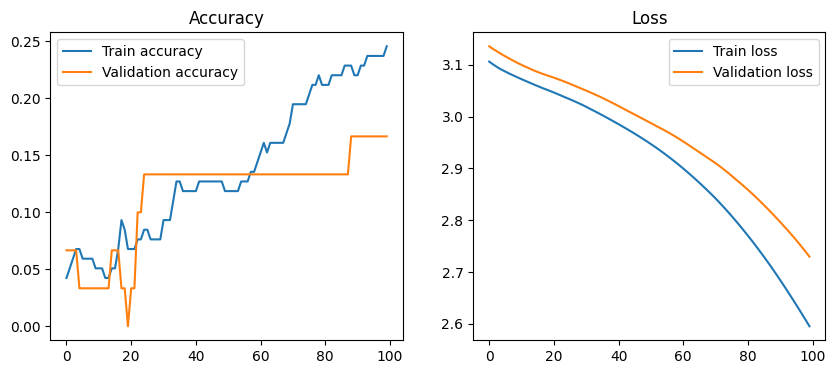

In [10]:
def training_predict_fish_model(csv_file_path, epochs=10, batch_size=32):
  df = pd.read_csv(csv_file_path)

  print(df.columns)
  print("Dataset Preview: ")
  print(df.head())

  # We encode species_name as integers
  df['species_name_encoder'] = df['species_name'].astype('category').cat.codes
  num_classes = df['species_name_encoder'].nunique()

  # Extracting the day_of_year feature
  df['date_catched'] = pd.to_datetime(df['date_catched'])
  df['date_of_year'] = df['date_catched'].dt.dayofyear


  # Features (X) and the Target (y)
  X = df[['latitude', 'longitude', 'temperature', 'date_of_year']]
  y = df['species_name_encoder']

  # Scaling features
  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)

  # Splitting dataset for training and testing
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
  y_train = y_train.to_numpy()

  # Computing the class weights
  class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
  class_weights_dict = dict(enumerate(class_weights))

  # print("Unique classes in y_train:", np.unique(y_train))
  # print("Class weights dictionary:", class_weights_dict)

  model = Sequential([
      Dense(64, activation='relu', input_dim=X_train.shape[1]),
      Dense(32, activation='relu'),
      Dense(num_classes, activation='softmax') #Multi-class output
  ])

  model.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  print(set(y_train))  # Show the unique class labels in y_train
  print(class_weights_dict.keys())

  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  history = model.fit(X_train, y_train.astype(int),
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(X_test,y_test),
                      class_weight=class_weights_dict,
                      callbacks=[early_stopping]
                      )

  # Evaluating the model
  loss, accuracy = model.evaluate(X_test, y_test)
  print(f'Loss: {loss}, Accuracy: {accuracy}')

  # Assigning plot metrics
  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train accuracy')
  plt.plot(history.history['val_accuracy'], label= 'Validation accuracy')
  plt.title('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.title('Loss')
  plt.legend()

  return model, history

csv_file_path = 'Sea_sense_d_data.csv'  # Replace with the actual path to your CSV file
model, history = training_predict_fish_model(csv_file_path, epochs=100, batch_size=128)

In [ ]:
  # print("Class weights dictionary passed to fit():", class_weights_dict)
  # print("Data type of keys in class_weights_dict:", [type(k) for k in class_weights_dict.keys()])
  # print("Data type of labels in y_train:", type(y_train.iloc[0]))

    # # Check the data type of y_train
  # print(f"Data type of y_train: {type(y_train)}")
  # print(f"Shape of y_train: {y_train.shape}")

  # # Check the data type of class_weights_dict
  # print(f"Data type of class_weights_dict: {type(class_weights_dict)}")
  # print(f"Content of class_weights_dict: {class_weights_dict}")